# Libraries

## General

In [1]:
import cv2
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
from yolov3.yolov4 import Create_Yolo
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *

%matplotlib inline

## YOLO

In [2]:
if YOLO_TYPE == "yolov4":
    Darknet_weights = YOLO_V4_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V4_WEIGHTS
if YOLO_TYPE == "yolov3":
    Darknet_weights = YOLO_V3_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V3_WEIGHTS

yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE)
load_yolo_weights(yolo, Darknet_weights) # use Darknet weights

## Open Pose

In [57]:
MODE = "COCO"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

# Running Open Pose on Single Person Image

In [59]:
image_path = 'yogapose4.jpg'

frame = cv2.imread(image_path)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

inWidth = frameWidth
inHeight = frameHeight

print(inWidth, inHeight)

650 350


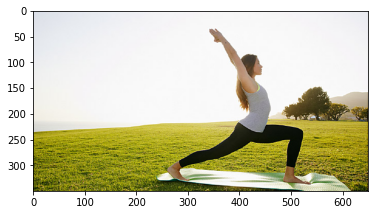

In [60]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

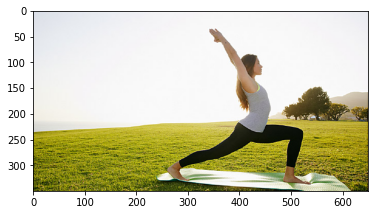

In [61]:
plt.imshow(frame)

In [50]:
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

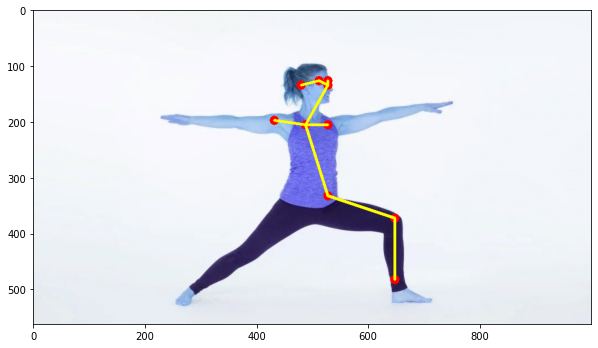

In [51]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
        
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [52]:
image,cl = detect_image(yolo, image_path, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

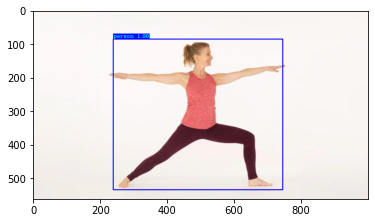

In [53]:
plt.imshow(image)

In [54]:
cl

{'person': [array([239.99516296,  86.03205872, 745.2512207 , 534.47198486,
           0.99989116,   0.        ])]}

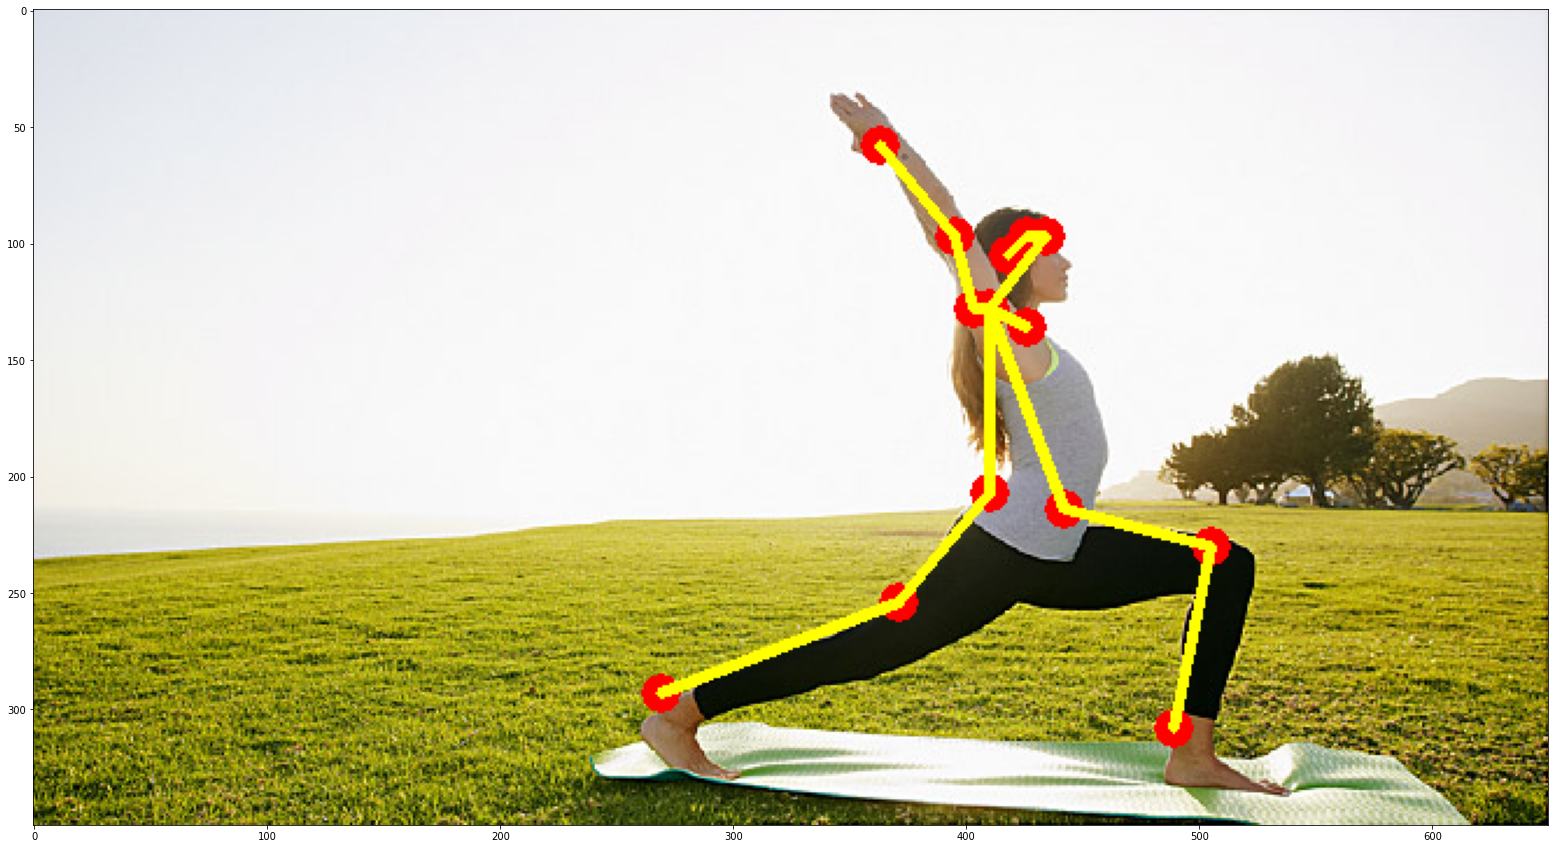

In [64]:
image_path = "yogapose4.jpg"
frame = cv2.imread(image_path)
image,cl = detect_image(yolo, image_path, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))

#frame = np.copy(image)
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
for key in cl:
    for val in cl['person']:
        inWidth = int(val[2] - val[0])
        inHeight = int(val[3] - val[1])
        inpBlob = cv2.dnn.blobFromImage(frame[int(val[1]):int(val[3])+1, int(val[0]):int(val[2])+1], 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inpBlob)

        output = net.forward()
        H = output.shape[2]
        W = output.shape[3]
        points = []
        original_points = []
        for i in range(nPoints):
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            # Scale the point to fit on the original image
            x = (inWidth * point[0]) / W
            y = (inHeight * point[1]) / H

            if prob > threshold : 
                cv2.circle(frame[int(val[1]):int(val[3])+1, int(val[0]):int(val[2])+1], (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

                # Add the point to the list if the probability is greater than the threshold
                points.append((int(x), int(y)))
            else :
                points.append(None)
        
        # Draw Skeleton
        for pair in POSE_PAIRS:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                cv2.line(frame[int(val[1]):int(val[3])+1, int(val[0]):int(val[2])+1], points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))